In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from lib.modules import (
    evaluate_loop, 
    read_and_window_session,
    read_session,
    read_labels,
    train_loop,
    optimization_loop,
    predict_and_plot_pretty_session
)
from lib.utils import (
    plot_and_save_cm,
    summary,
    get_bouts,
    get_bouts_smoothed
)
from lib.models import  MLP, MLP2hl, LSTM
from tqdm import tqdm
import plotly.express as px
from tabulate import tabulate
import numpy as np
import pandas as pd

/home/mmazeem/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
raw_dir = Path("/home/mmazeem/datasets/nursingv1")
label_dir = Path("/home/mmazeem/datasets/eating_labels")
WINSIZE = 505
DEVICE = 'cuda'

In [21]:
train_sessions = [25, 67, 42]
test_sessions = [58, 62, 24]

Xs = []
ys = []

for session_idx in train_sessions:
    X,y = read_and_window_session(session_idx, WINSIZE, raw_dir, label_dir)

    Xs.append(X)
    ys.append(y)

Xtr = torch.cat(Xs)
ytr = torch.cat(ys)

Xs = []
ys = []

for session_idx in test_sessions:
    X,y = read_and_window_session(session_idx, WINSIZE, raw_dir, label_dir)

    Xs.append(X)
    ys.append(y)

Xte = torch.cat(Xs)
yte = torch.cat(ys)

In [22]:
model = LSTM(winsize=WINSIZE, subwinsize=101).to(DEVICE)
# model = MLP(n_hl=50, winsize=WINSIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

In [24]:
trainloader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)
testloader = DataLoader(TensorDataset(Xte,yte), batch_size=64)

optimization_loop(model, trainloader, testloader, criterion, optimizer, 5, DEVICE, Path('dev/lstm_window'))

  0%|          | 0/5 [00:00<?, ?it/s]

In [53]:
model.load_state_dict(torch.load(Path('dev/lstm/best_model.pt')))
# model.load_state_dict(torch.load(Path('dev/mlp/best_model.pt')))

<All keys matched successfully>

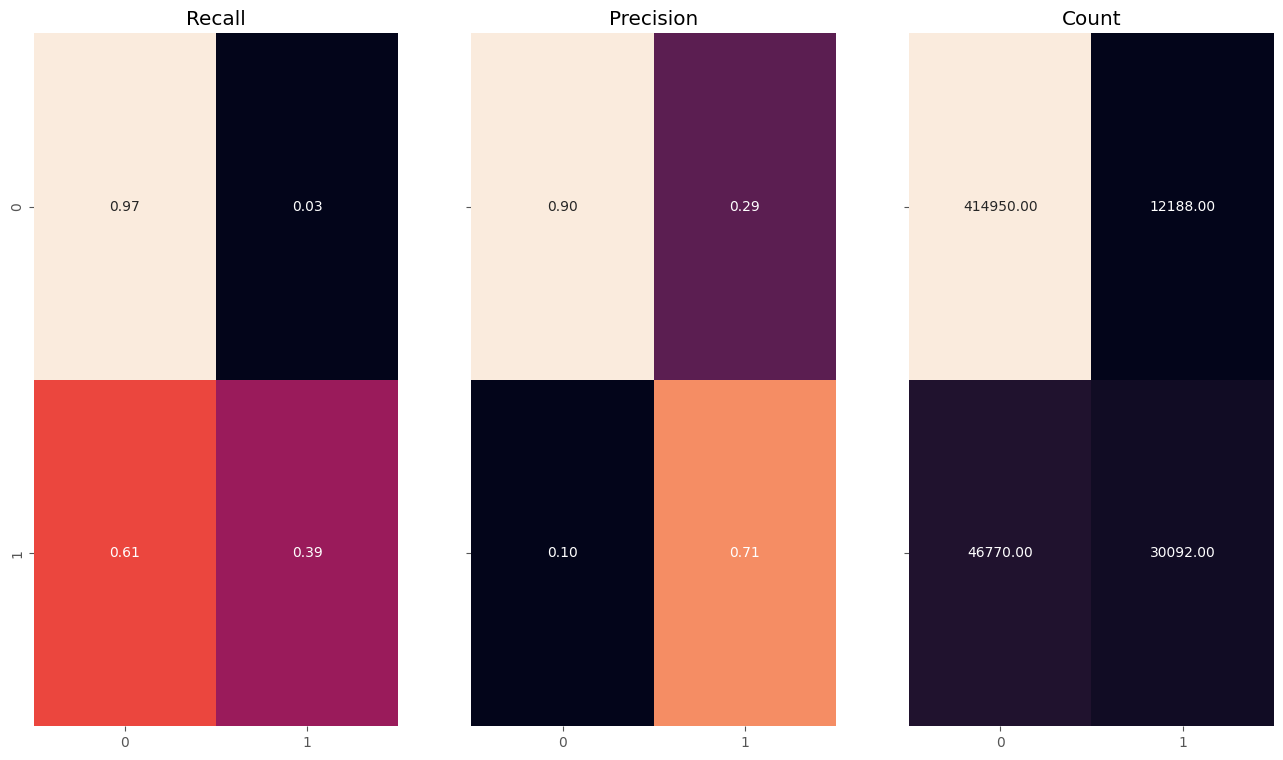

Metric        Value
---------  --------
loss       0.291942
precision  0.711731
recall     0.391507
f1         0.505145


In [49]:
ys,metrics = evaluate_loop(model, criterion, trainloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)

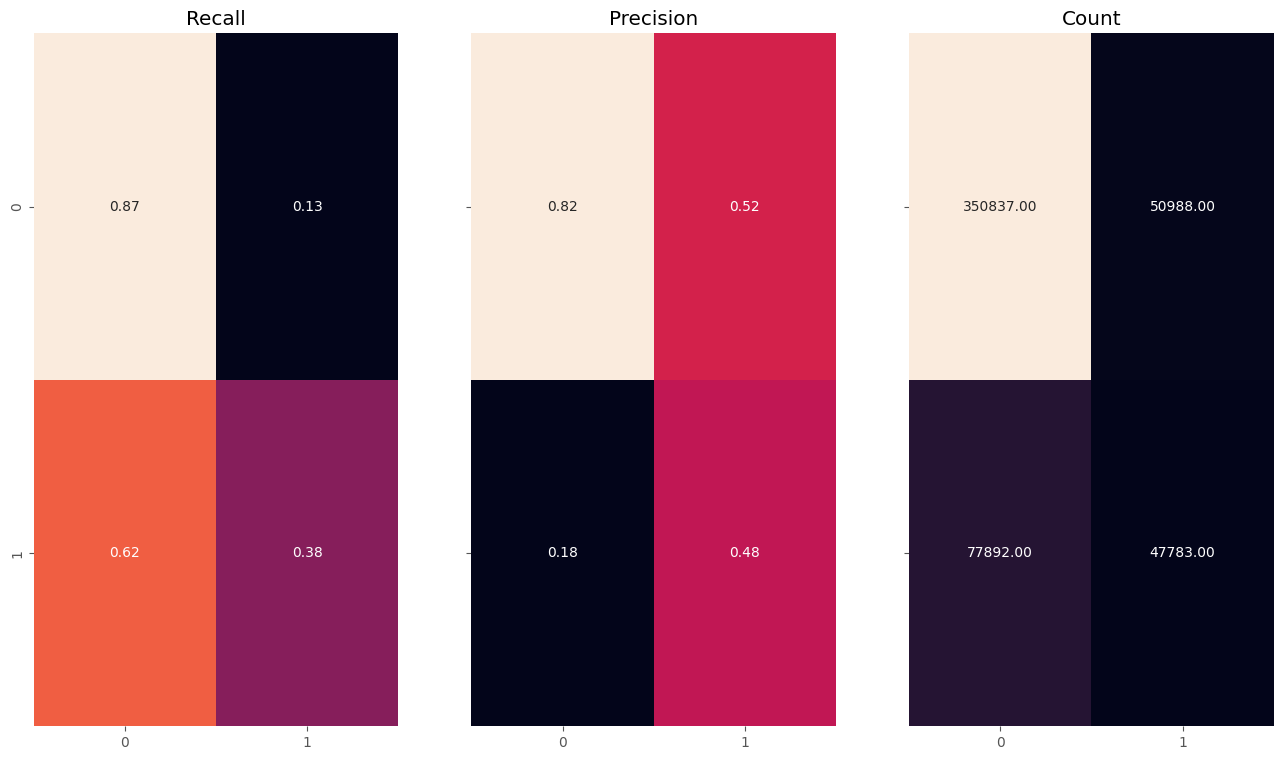

Metric        Value
---------  --------
loss       0.879803
precision  0.483776
recall     0.380211
f1         0.425786


In [54]:
ys,metrics = evaluate_loop(model, criterion, testloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)

In [110]:
from lib.utils import get_bouts
from lib.modules import read_session, read_labels

test_session = test_sessions[0]

X,y = read_and_window_session(test_session, WINSIZE, raw_dir, label_dir)
ys, metrics = evaluate_loop(
    model, 
    criterion, 
    DataLoader(TensorDataset(X, y), 64), 
    DEVICE
)

In [113]:
pred_bouts = get_bouts_smoothed(ys['pred'])

               start            end          len           gap
count      56.000000      56.000000    56.000000     55.000000
mean   100194.696429  100942.053571   747.357143   2763.381818
std     61656.304997   61490.406577   801.437241   3150.665300
min      7959.000000    8024.000000     1.000000    634.000000
25%     45826.000000   45986.750000   135.000000    818.000000
50%     92486.000000   93010.500000   442.500000   1531.000000
75%    152373.500000  152810.750000  1204.250000   3008.000000
max    201222.000000  201797.000000  2868.000000  14530.000000


<Axes: >

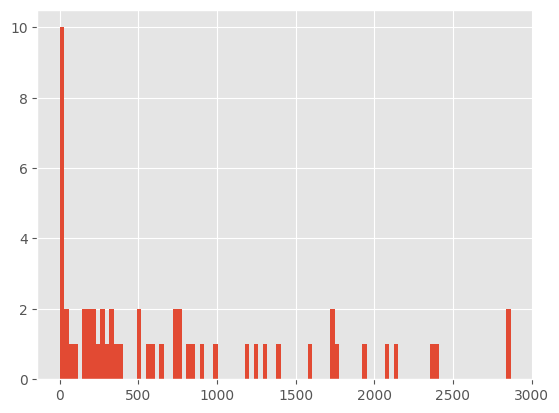

In [117]:
gaps = []
for i,b in enumerate(pred_bouts[:-1]):
    gaps.append(pred_bouts[i+1]["start"] - b["end"]) 
gaps.append(np.nan)

b = pd.DataFrame({
    "start": [b['start'] for b in pred_bouts],
    "end": [b['end'] for b in pred_bouts],
    "len":[b['end']-b['start'] for b in pred_bouts],
    "gap": gaps
})
print(b.describe())
b["len"].hist(bins=100)

In [120]:
# test_session = test_sessions[0]

predict_and_plot_pretty_session(
    session_idx=test_session,
    dim_factor=5,
    datapath=raw_dir,
    labelpath=label_dir,
    winsize=WINSIZE,
    model=model,
    criterion=criterion,
    batch_size=64,
    device=DEVICE
)

Metric        Value
---------  --------
loss       0.659991
precision  0.489004
recall     0.228495
f1         0.311457


Gtk-Message: 15:13:17.761: Failed to load module "xapp-gtk3-module"
Gtk-Message: 15:13:17.762: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
Gtk-Message: 15:13:17.762: Failed to load module "appmenu-gtk-module"

(brave:15231): Gtk-WARNING **: 15:13:17.839: GTK+ module /snap/brave/295/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 15:13:17.839: Failed to load module "canberra-gtk-module"

(brave:15231): Gtk-WARNING **: 15:13:17.839: GTK+ module /snap/brave/295/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 15:13:17.839: Failed to load module "canberra-gtk-module"


Opening in existing browser session.
